Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

In [2]:
# Common imports & helper functions

import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
def get_log_files(pattern, extra):
    files = glob.glob(pattern)
    if extra:
        files.append(extra)
    return sorted(files)

def extract_best_metrics(paths):
    records = []
    for p in paths:
        model = p.split('/')[-1].split('_')[1]
        df = pd.read_csv(p, parse_dates=['timestamp'])
        best = df.loc[df['val_f1'].idxmax()]
        duration = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()/60
        records.append({
            'model': model,
            'best_epoch': int(best['epoch']),
            'val_f1': float(best['val_f1']),
            'val_acc': float(best['val_acc']),
            'val_precision': float(best['val_precision']),
            'val_recall': float(best['val_recall']),
            'training_time_min': duration
        })
    return pd.DataFrame(records).sort_values('val_f1', ascending=False).reset_index(drop=True)

def pareto_front_indices(df):
    idxs = []
    for i, ri in df.iterrows():
        dominated = any(
            (rj['val_f1'] >= ri['val_f1']) and (rj['training_time_min'] <= ri['training_time_min'])
            for j, rj in df.iterrows() if j != i
        )
        if not dominated:
            idxs.append(i)
    return idxs

def plot_bars(df, title_prefix):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
    ax1.barh(df['model'], df['val_f1']); ax1.invert_yaxis()
    ax1.set_xlabel('Val F1'); ax1.set_title(f'{title_prefix} F1')
    ax2.barh(df['model'], df['training_time_min']); ax2.invert_yaxis()
    ax2.set_xlabel('Time (min)'); ax2.set_title(f'{title_prefix} Time')
    plt.tight_layout(); plt.show()

def plot_pareto(df: pd.DataFrame, pareto_idxs: list[int], domain: str) -> None:
    sns.set(style="darkgrid", font_scale=1.1)
    
    # build an evenly‐spaced Viridis colormap
    unique_models = df['model'].tolist()
    cmap = sns.color_palette("viridis", as_cmap=True)
    colors = [cmap(x) for x in np.linspace(0, 1, len(unique_models))]
    color_map = dict(zip(unique_models, colors))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, row in df.iterrows():
        m, f1, t = row['model'], row['val_f1'], row['training_time_min']
        is_pareto = idx in pareto_idxs

        ax.scatter(
            t,
            f1,
            s=180 if is_pareto else 100,
            marker='^' if is_pareto else 'o',
            color=color_map[m],
            edgecolor='gray',
            linewidth=0.8,
            zorder=3 if is_pareto else 2,
            label=f"{m} ({f1:.4f})"
        )

    ax.set_xlabel('Training Time (minutes)', fontsize=12)
    ax.set_ylabel('Best Validation F1',       fontsize=12)
    ax.margins(y=0.04)

    ax.legend(
        title='Model (▲ = Pareto-optimal)',
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        frameon=False,
        fontsize=10,
        title_fontsize=10,
        labelspacing=1.3
    )

    plt.tight_layout(rect=(0, 0, 0.85, 1))
    plt.show()

## DGA

Found 11 DGA logs.


,model,best_epoch,val_f1,val_acc,val_precision,val_recall,training_time_min
0,prajjwal1-bert-medium,6,0.986082,0.98600,0.983930,0.988243,6.650000
1,google-electra-base-discriminator,3,0.985918,0.98580,0.981344,0.990535,14.550000
2,prajjwal1-bert-small,10,0.985008,0.98485,0.978376,0.991731,4.666667
3,distilbert-base-uncased,9,0.984839,0.98470,0.979501,0.990236,9.333333
4,prajjwal1-bert-mini,9,0.984597,0.98445,0.978925,0.990336,3.966667
5,google-electra-small-discriminator,11,0.984585,0.98450,0.982825,0.986351,7.200000
6,distilbert-base-cased,9,0.984336,0.98420,0.979481,0.989240,9.266667
7,albert-base-v2,6,0.983786,0.98375,0.985212,0.982365,18.766667
8,prajjwal1-bert-tiny,11,0.979254,0.97905,0.973327,0.985255,2.783333
9,custom-char,19,0.956921,0.95685,0.959652,0.954206,1.516667


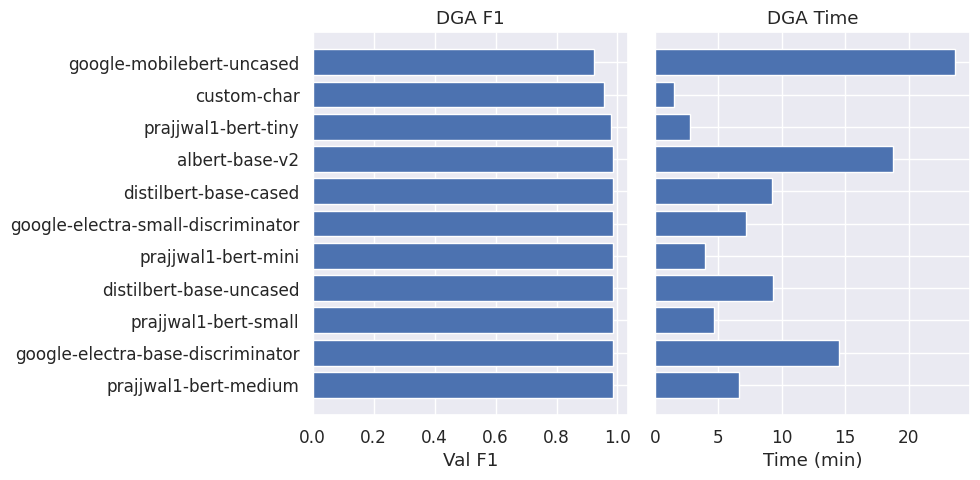

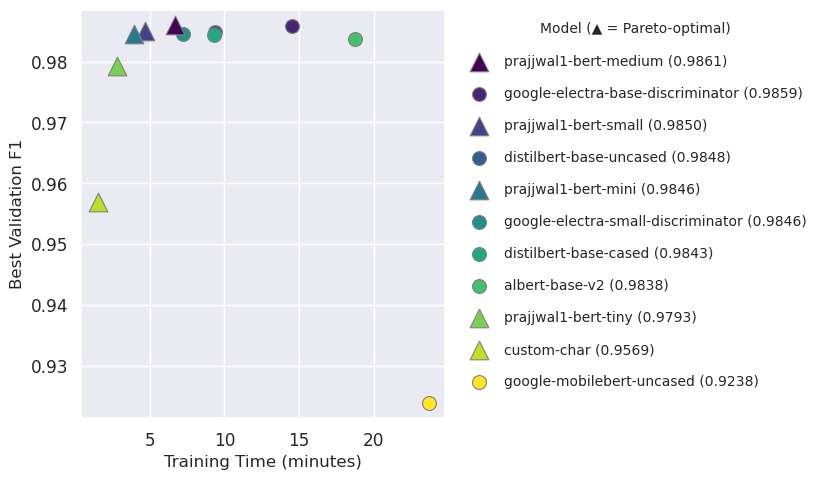

In [9]:
# Configure and process DGA logs
dga_cfg = {
    'pattern': '../logs/domain/dga_*_training_logs_2025050[3-4]_*.csv',
    'extra': '../logs/domain/dga_custom-char_20250516_040504.csv'
}

dga_files = get_log_files(dga_cfg['pattern'], dga_cfg['extra'])
print(f"Found {len(dga_files)} DGA logs.")
dga_df = extract_best_metrics(dga_files)
display(dga_df)

# Visualizations
plot_bars(dga_df, 'DGA')
dga_pareto = pareto_front_indices(dga_df)
plot_pareto(dga_df, dga_pareto, 'DGA')


## Malware

Found 11 Malware logs.


,model,best_epoch,val_f1,val_acc,val_precision,val_recall,training_time_min
0,google-electra-base-discriminator,8,0.898238,0.89660,0.887409,0.909335,19.283333
1,distilbert-base-uncased,5,0.887906,0.88465,0.866559,0.910332,9.250000
2,distilbert-base-cased,6,0.886996,0.88590,0.881756,0.892298,10.383333
3,prajjwal1-bert-small,10,0.886121,0.88250,0.862629,0.910930,5.166667
4,prajjwal1-bert-medium,5,0.883474,0.88020,0.862993,0.904952,7.450000
5,google-electra-small-discriminator,10,0.882710,0.88125,0.875147,0.890405,7.116667
6,prajjwal1-bert-mini,6,0.882177,0.87770,0.853959,0.912324,2.733333
7,albert-base-v2,4,0.881374,0.87880,0.866115,0.897180,18.750000
8,prajjwal1-bert-tiny,11,0.871607,0.86495,0.833455,0.913420,2.516667
9,google-mobilebert-uncased,39,0.862041,0.85595,0.829891,0.896782,55.766667


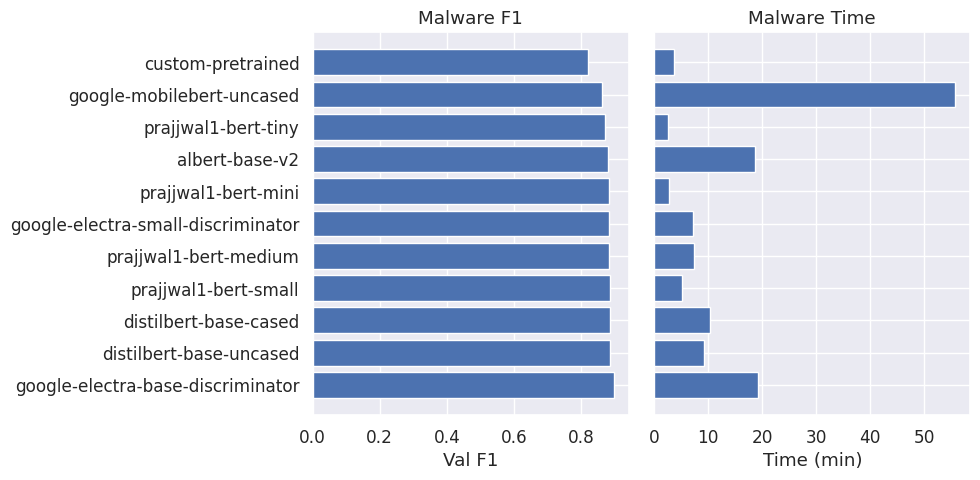

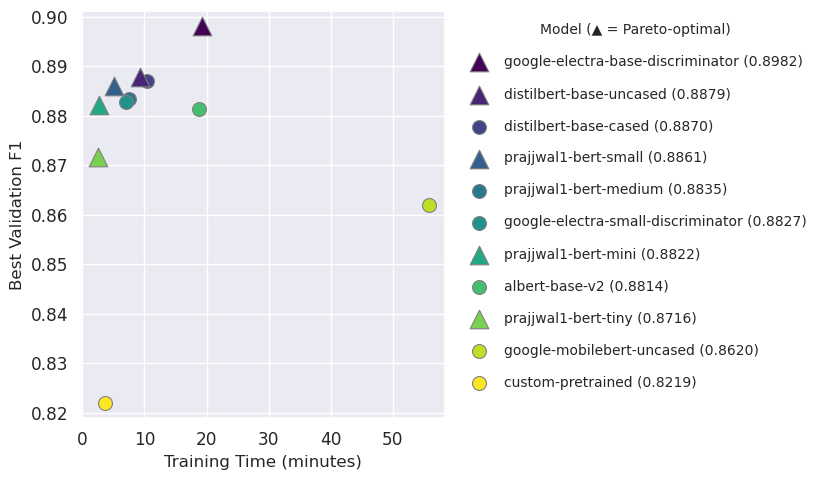

In [10]:
# Configure and process Malware logs
malware_cfg = {
    'pattern': '../logs/domain/malware_*_training_logs_2025050[3-4]_*.csv',
    'extra': '../logs/domain/malware_custom-pretrained_20250516_042434.csv'
}

malware_files = get_log_files(malware_cfg['pattern'], malware_cfg['extra'])
print(f"Found {len(malware_files)} Malware logs.")
malware_df = extract_best_metrics(malware_files)
display(malware_df)

# Visualizations
plot_bars(malware_df, 'Malware')
malware_pareto = pareto_front_indices(malware_df)
plot_pareto(malware_df, malware_pareto, 'Malware')


## Phishing

Found 11 Phishing logs.


,model,best_epoch,val_f1,val_acc,val_precision,val_recall,training_time_min
0,google-electra-base-discriminator,5,0.944519,0.94445,0.946836,0.942214,19.416667
1,distilbert-base-uncased,7,0.942316,0.94255,0.949707,0.935040,9.333333
2,prajjwal1-bert-medium,10,0.941995,0.94165,0.939893,0.944107,9.183333
3,distilbert-base-cased,7,0.941277,0.94130,0.945153,0.937432,11.616667
4,google-electra-small-discriminator,13,0.940622,0.94075,0.946169,0.935140,6.200000
5,prajjwal1-bert-small,12,0.940269,0.94000,0.939521,0.941018,5.716667
6,albert-base-v2,4,0.938670,0.93955,0.956180,0.921789,18.783333
7,prajjwal1-bert-mini,10,0.937368,0.93780,0.947481,0.927468,3.550000
8,prajjwal1-bert-tiny,14,0.925482,0.92470,0.919296,0.931753,3.466667
9,google-mobilebert-uncased,39,0.893671,0.89180,0.881629,0.906048,55.950000


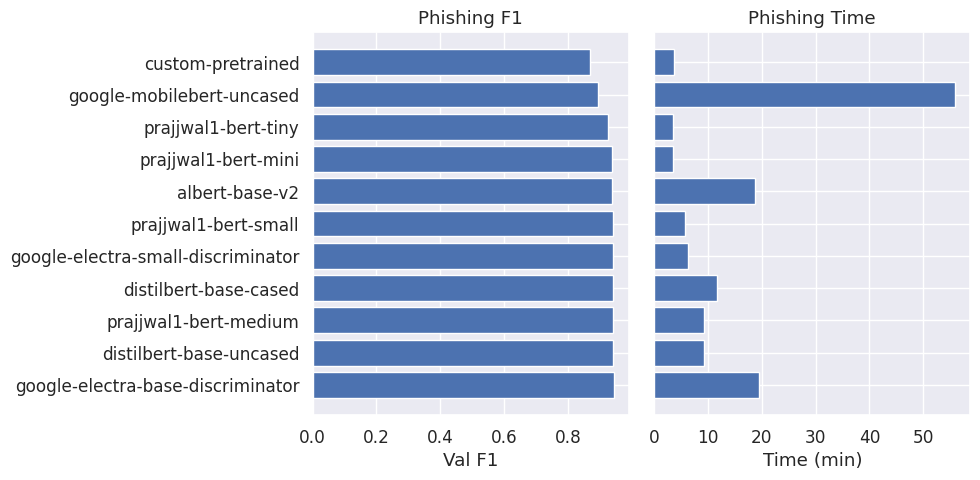

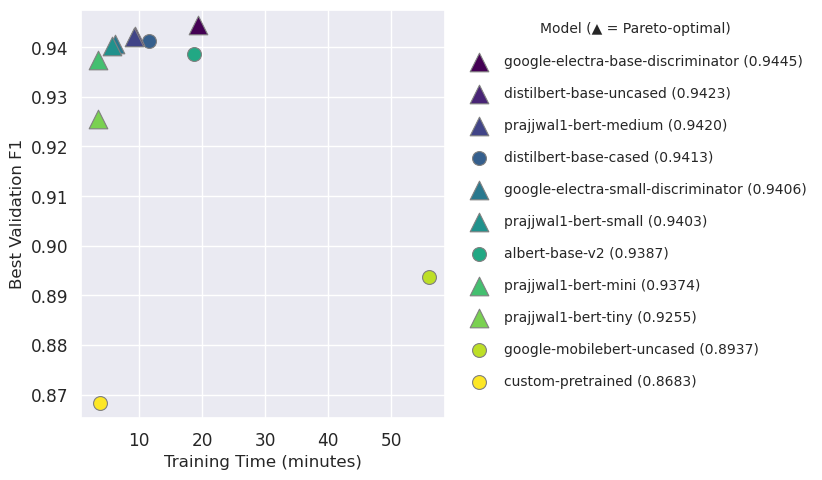

In [11]:
# Configure and process Phishing logs
phish_cfg = {
    'pattern': '../logs/domain/phish_*_training_logs_2025050[3-4]_*.csv',
    'extra': '../logs/domain/phishing_custom-pretrained_20250516_043428.csv'
}

phish_files = get_log_files(phish_cfg['pattern'], phish_cfg['extra'])
print(f"Found {len(phish_files)} Phishing logs.")
phish_df = extract_best_metrics(phish_files)
display(phish_df)

# Visualizations
plot_bars(phish_df, 'Phishing')
phish_pareto = pareto_front_indices(phish_df)
plot_pareto(phish_df, phish_pareto, 'Phishing')